# **Machine Learning Methods using German Credit Data**

When a bank receives a loan application, based on the applicant’s profile the bank has to make a decision regarding whether to go ahead with the loan approval or not. Two types of risks are associated with the bank’s decision –

If the applicant is a good credit risk, i.e. is likely to repay the loan, then not approving the loan to the person results in a loss of business to the bank
If the applicant is a bad credit risk, i.e. is not likely to repay the loan, then approving the loan to the person results in a financial loss to the bank.\

The German Credit Data contains data on 20 variables and the classification whether an applicant is considered a Good or a Bad credit risk for 1000 loan applicants.

https://www.openml.org/search?type=data&sort=runs&id=31&status=active

## **Data Import and Initial Data Analysis**

In [708]:
import pandas as pd
import numpy as np
import json
import os
import urllib.request# import libraires 

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, spearmanr
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [578]:
from scipy.stats import chi2_contingency
import numpy as np
# Function to calculate Cramér's V statistic
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min((k-1), (r-1)))

# Example: Association between 'purpose' and 'credit_risk'
# cramers_v(df['purpose'], df['property_magnitude'])

In [579]:
def continuous_correlation_table(df, continuous_cols=None):
    """
    Compute Pearson correlation and p-values for all pairs of continuous variables
    
    Parameters:
    - df: Pandas DataFrame
    - continuous_cols: List of continuous column names (if None, use numeric columns)
    
    Returns:
    - DataFrame with columns: ['variable1', 'variable2', "Pearson's r", "p-value"]
    """
    # Select continuous variables if not specified
    if continuous_cols is None:
        continuous_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Initialize results list
    results = []
    
    # Compute for all unique pairs
    for col1, col2 in combinations(continuous_cols, 2):
        # Remove missing values pairwise
        clean_df = df[[col1, col2]].dropna()
        
        # Initialize defaults
        pearson_rho = pearson_p = np.nan
        spearman_rho = spearman_p = np.nan
        
        try:
            # Pearson correlation
            pearson_rho, pearson_p = pearsonr(clean_df[col1], clean_df[col2])
            
            # Spearman's rank correlation
            spearman_rho, spearman_p = spearmanr(clean_df[col1], clean_df[col2])
        except:
            pass
        
        # Store results
        results.append({
            'variable1': col1,
            'variable2': col2,
            "pearson_rho": pearson_rho,
            "pearson_p": pearson_p,
            'spearman_rho': spearman_rho,
            'spearman_p': spearman_p
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df[results_df['variable1'] != results_df['variable2']]  # Remove self-comparisons    
    return results_df

In [580]:
def categorical_association_table(df, categorical_columns=None):
    """
    Compute Cramér's V and Chi-Square test for all pairs of categorical variables.
    Returns results in a row-wise format (long format).
    
    Parameters:
    - df: Pandas DataFrame
    - categorical_columns: List of categorical column names (if None, use all object/bool columns)
    
    Returns:
    - DataFrame with columns: ['variable1', 'variable2', "Cramér's V", "Chi-Square p-value"]
    """
    # Select categorical columns if not provided
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    
    # Initialize results list
    results = []
    
    # Compute for all unique pairs
    for col1, col2 in combinations(categorical_columns, 2):
        # Create contingency table
        contingency_table = pd.crosstab(df[col1], df[col2])
        
        # Chi-Square test
        try:
            chi2, p, _, _ = chi2_contingency(contingency_table)
        except:
            chi2, p = np.nan, np.nan
        
        # Cramér's V
        try:
            cv = cramers_v(df[col1], df[col2])
        except:
            cv = np.nan
        
        # Store results
        results.append({
            'variable1': col1,
            'variable2': col2,
            "Cramér's V": cv,
            "Chi-Square p-value": p
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df[results_df['variable1'] != results_df['variable2']]  # Remove self-comparisons
    
    return results_df

In [581]:
# Function for evaluation reports
def get_eval(clf, X_train, y_train,y_test,y_pred):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    scores2 = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
    scores3 = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    # Create and print confusion matrix
    abclf_cm = confusion_matrix(y_test,y_pred)
    print(abclf_cm)
    return

# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return

In [ ]:
# fit, train and cross validate Decision Tree with training and test data 
def logregclf(X_train, y_train,X_test, y_test):
    print("LogisticRegression")
    logreg = LogisticRegression(max_iter=10000).fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = logreg.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Get Cross Validation and Confusion matrix
    get_eval(logreg, X_train, y_train,y_test,y_pred)
    return

In [582]:
# function groupby_counts to calculate the counts and default rates for categorical variables
def groupby_counts(df, var, desired_order=None):
    df_var =  df.groupby([var]).agg(    
        Total = (var, 'count'),
        good = ('credit_class', lambda x: (x == 'good').sum()),
        bad = ('credit_class', lambda x: (x == 'bad').sum()),
        DefaultRate = ('credit_class', lambda x: (x == 'bad').sum() / len(x))
        ).reset_index()
    
    if desired_order is not None:
        df_var[var] = pd.Categorical(df_var[var], categories=desired_order, ordered=True)

    df_var = df_var.sort_values(var).reset_index(drop=True)
    return df_var


In [583]:
# function plot_distribution to plot the distribution and default rates for categorical variables
def plot_distribution(df_var, var, value_map=None, loc = (0.7,0.7)):
    
    plt.figure(figsize=(6,4))
    plt.bar(df_var[var], df_var['Total'])
    plt.xlabel(var, fontsize=14)
    plt.xticks(rotation=30)
    plt.ylabel('Count')
    plt.title('Distribution of '+var, fontsize=16, fontweight='bold')

    # Add secondary y-axis for DefaultRate
    ax2 = plt.twinx()
    ax2.plot(df_var[var], df_var['DefaultRate'], color='red', marker='o', label='Default Rate')
    ax2.set_ylabel('Default Rate')

      # Add legend for value_map if provided
    if value_map is not None:
      # Build legend labels
      legend_labels = [f"{v}: {k}" for k, v in value_map.items()]
      # handles = [plt.Rectangle((0,0),1,1, color='white', ec='black', label=f"{k}: {v}") for k, v in value_map.items()]
      desc_text = "xlabels:\n" + "\n".join(legend_labels)
      plt.gcf().text(loc[0], loc[1], desc_text, fontsize=8, 
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.3))
      # plt.legend(handles=handles, title="account_bal_new meaning", loc='upper left')

    plt.show()

In [ ]:
def plot_categorical_heatmap(df, var1, var2):
    """
    Plot a heatmap showing frequency relationships between two categorical variables
    
    Parameters:
    - df: DataFrame
    - var1: First categorical variable (str)
    - var2: Second categorical variable (str)
    """
    # Create contingency table
    crosstab = pd.crosstab(df[var1], df[var2])
    
    # Create plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(crosstab, 
                annot=True, 
                fmt='d', 
                cmap='coolwarm', 
                linewidths=.5,
                cbar_kws={'label': 'Count'})
    
    plt.title(f'Relationship between {var1} and {var2}', pad=20)
    plt.xlabel(var2)
    plt.ylabel(var1)
    plt.show()

In [ ]:
def plot_roc_curve(fpr, tpr, roc_auc):
    """
    Plot the ROC curve.
    fpr: false positive rate value, 
    tpr: true positive rate value, 
    roc_auc : roc_auc output from roc_auc_score( )
    """
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [584]:
def getdata (filepath):
    with open (filepath,'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    return df

**Import the data**

In [585]:
file=os.getcwd()+"\\german_credit_data.json"

In [586]:
df = getdata(file)

In [587]:
df.shape

(1000, 21)

In [588]:
df.head()

,age,checking_status,class,credit_amount,credit_history,duration,employment,existing_credits,foreign_worker,housing,...,job,num_dependents,other_parties,other_payment_plans,own_telephone,personal_status,property_magnitude,purpose,residence_since,savings_status
0,67,<0,good,1169,critical/other existing credit,6,>=7,2,yes,own,...,skilled,1,none,none,yes,male single,real estate,radio/tv,4,no known savings
1,22,0<=X<200,bad,5951,existing paid,48,1<=X<4,1,yes,own,...,skilled,1,none,none,none,female div/dep/mar,real estate,radio/tv,2,<100
2,49,no checking,good,2096,critical/other existing credit,12,4<=X<7,1,yes,own,...,unskilled resident,2,none,none,none,male single,real estate,education,3,<100
3,45,<0,good,7882,existing paid,42,4<=X<7,1,yes,for free,...,skilled,2,guarantor,none,none,male single,life insurance,furniture/equipment,4,<100
4,53,<0,bad,4870,delayed previously,24,1<=X<4,2,yes,for free,...,skilled,2,none,none,none,male single,no known property,new car,4,<100


In [589]:
print(df.columns)

Index(['age', 'checking_status', 'class', 'credit_amount', 'credit_history',
       'duration', 'employment', 'existing_credits', 'foreign_worker',
       'housing', 'installment_commitment', 'job', 'num_dependents',
       'other_parties', 'other_payment_plans', 'own_telephone',
       'personal_status', 'property_magnitude', 'purpose', 'residence_since',
       'savings_status'],
      dtype='object')


In [590]:
def rename_data(df, rename_dict):

    df.rename(columns=rename_dict, inplace=True)#rename columns
    
    return df


In [591]:
cols = {'class':'credit_class','checking_status': 'account_bal', 'other_parties':'guarantors', 'savings_status':'savings_value'}
df = rename_data(df, cols)

In [592]:
df['credit_amount'] = df['credit_amount'].astype(float)

In [593]:
df.dtypes

age                         int64
account_bal                object
credit_class               object
credit_amount             float64
credit_history             object
duration                    int64
employment                 object
existing_credits            int64
foreign_worker             object
housing                    object
installment_commitment      int64
job                        object
num_dependents              int64
guarantors                 object
other_payment_plans        object
own_telephone              object
personal_status            object
property_magnitude         object
purpose                    object
residence_since             int64
savings_value              object
dtype: object

In [594]:
df.isnull().sum(axis=0)

age                       0
account_bal               0
credit_class              0
credit_amount             0
credit_history            0
duration                  0
employment                0
existing_credits          0
foreign_worker            0
housing                   0
installment_commitment    0
job                       0
num_dependents            0
guarantors                0
other_payment_plans       0
own_telephone             0
personal_status           0
property_magnitude        0
purpose                   0
residence_since           0
savings_value             0
dtype: int64

Lets summarise few numerical columns

In [595]:
df.describe()

,age,credit_amount,duration,existing_credits,installment_commitment,num_dependents,residence_since
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000,1.407000,2.973000,1.155000,2.845000
std,11.375469,2822.736876,12.058814,0.577654,1.118715,0.362086,1.103718
min,19.000000,250.000000,4.000000,1.000000,1.000000,1.000000,1.000000
25%,27.000000,1365.500000,12.000000,1.000000,2.000000,1.000000,2.000000
50%,33.000000,2319.500000,18.000000,1.000000,3.000000,1.000000,3.000000
75%,42.000000,3972.250000,24.000000,2.000000,4.000000,1.000000,4.000000
max,75.000000,18424.000000,72.000000,4.000000,4.000000,2.000000,4.000000


### Remap categorical fields

In [596]:
df.head()

,age,account_bal,credit_class,credit_amount,credit_history,duration,employment,existing_credits,foreign_worker,housing,...,job,num_dependents,guarantors,other_payment_plans,own_telephone,personal_status,property_magnitude,purpose,residence_since,savings_value
0,67,<0,good,1169.0,critical/other existing credit,6,>=7,2,yes,own,...,skilled,1,none,none,yes,male single,real estate,radio/tv,4,no known savings
1,22,0<=X<200,bad,5951.0,existing paid,48,1<=X<4,1,yes,own,...,skilled,1,none,none,none,female div/dep/mar,real estate,radio/tv,2,<100
2,49,no checking,good,2096.0,critical/other existing credit,12,4<=X<7,1,yes,own,...,unskilled resident,2,none,none,none,male single,real estate,education,3,<100
3,45,<0,good,7882.0,existing paid,42,4<=X<7,1,yes,for free,...,skilled,2,guarantor,none,none,male single,life insurance,furniture/equipment,4,<100
4,53,<0,bad,4870.0,delayed previously,24,1<=X<4,2,yes,for free,...,skilled,2,none,none,none,male single,no known property,new car,4,<100


In [597]:
account_bal_map = {
    'no checking': '0',
    '<0': '1',
    '0<=X<200': '2',
    '>=200': '3'
}

credit_history_map = {
    'critical/other existing credit' : '0', 
    'existing paid' : '1',
    'delayed previously' : '2',
    'no credits/all paid' : '3',
    'all paid' : '4'
    }
employment_map = {
    'unemployed': '0',
    '<1': '1',
    '1<=X<4': '2',
    '4<=X<7': '3',
    '>=7': '4'
}

housing_map = {
    'own': '0',
    'for free': '1',
    'rent': '2'
}

job_map = {
    'skilled': '0',
    'unskilled resident': '1',
    'unemp/unskilled non res': '2',
    'management/self employed': '3',
    'high qualif/self emp/mgmt': '4'
}

guarantors_map = {
    'none': '0',
    'co applicant': '1',
    'guarantor': '2'
}

other_payment_plans_map = {
    'bank': '0',
    'stores': '1',
    'none': '2'
}

personal_status_map = { 
    'female div/dep/mar': '0', 
    'male div/sep': '1',
    'male mar/wid': '2',
    'male single': '3'
}
property_magnitude_map = {
    'real estate': '0',
    'life insurance': '1',
    'car': '2',
    'no known property': '3'
}
purpose_map = {
    'radio/tv': '0',
    'furniture/equipment': '1',
    'domestic appliance': '2',
    'repairs': '3',
    'education': '4',
    'other': '5',
    'business': '6',
    'used car': '7',
    'new car': '8',
    'retraining': '9'
}

savings_value_map = {
    'no known savings': '0',
    '<100': '1',
    '100<=X<500': '2',
    '500<=X<1000': '3',
    '>=1000': '4'
}

In [598]:
df['account_bal_new'] = df['account_bal'].map(account_bal_map) 
df['credit_history_new'] = df['credit_history'].map(credit_history_map)
df['employment_new'] = df['employment'].map(employment_map)
df['housing_new'] = df['housing'].map(housing_map)
df['job_new'] = df['job'].map(job_map)
df['guarantors_new'] = df['guarantors'].map(guarantors_map)
df['other_payment_plans_new'] = df['other_payment_plans'].map(other_payment_plans_map)
df['personal_status_new'] = df['personal_status'].map(personal_status_map)
df['property_magnitude_new'] = df['property_magnitude'].map(property_magnitude_map)
df['purpose_new'] = df['purpose'].map(purpose_map)
df['savings_value_new'] = df['savings_value'].map(savings_value_map)

## **Exploratory Data Analysis**

### credit class

what is the distribution of good and bad customers in the data.


Average Age by credit_class
credit_class
bad     0.3
good    0.7
Name: age, dtype: float64


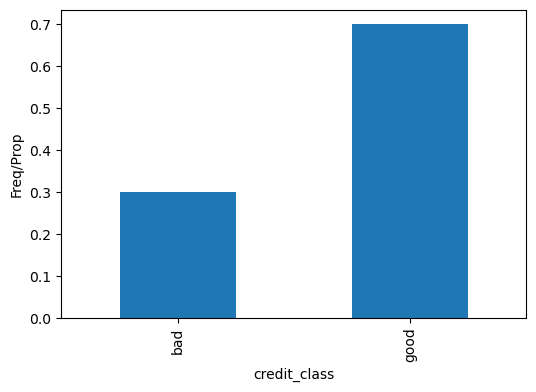

In [599]:
calc = round(df.groupby(['credit_class'])["age"].count()/df.shape[0], 2)
print('\nAverage Age by credit_class')
print(calc)

fig, ax = plt.subplots(figsize=(6,4))
ax.set_ylabel('Freq/Prop')
calc.plot(ax = ax, kind='bar', xlabel='credit_class')
plt.show()

### Credit amount

In [600]:
# average value of Credit amount?
calc = df["credit_amount"].describe()
print('\nAverage Credit amount summary statistics:\n')
print(calc)


Average Credit amount summary statistics:

count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: credit_amount, dtype: float64


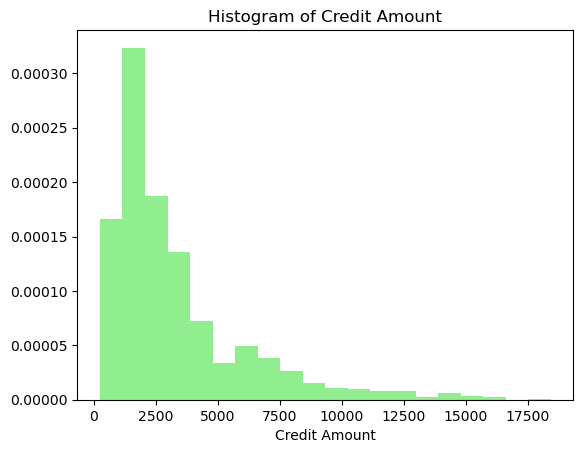

In [601]:
plt.hist(df['credit_amount'], bins=20, color='lightgreen',  density=True)
plt.xlabel("Credit Amount")
plt.title("Histogram of Credit Amount")

plt.show()

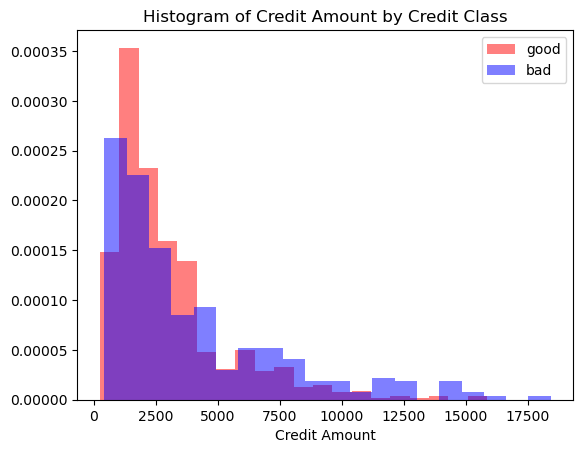

In [602]:
# plot the share of population in different classes of credit Amount

plt.hist(df[df.credit_class=='good']['credit_amount'],  bins=20, alpha=0.5, label='good', color='red',density=True)
plt.hist(df[df.credit_class=='bad']['credit_amount'],  bins=20, alpha=0.5, label='bad', color='blue',density=True)
plt.xlabel("Credit Amount")
plt.legend()
plt.title("Histogram of Credit Amount by Credit Class")

plt.show()

### age

In [603]:
# what is the average value of age?
calc = df["age"].describe()
print('\nAverage Age')
print(calc)


Average Age
count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: age, dtype: float64


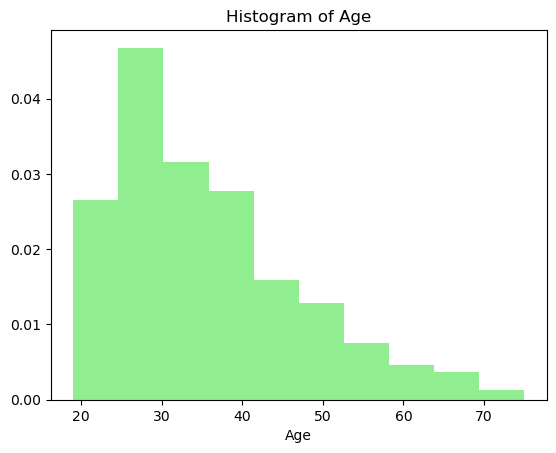

In [604]:
plt.hist(df['age'], color='lightgreen',  density=True)
plt.xlabel("Age")
plt.title("Histogram of Age")

plt.show()

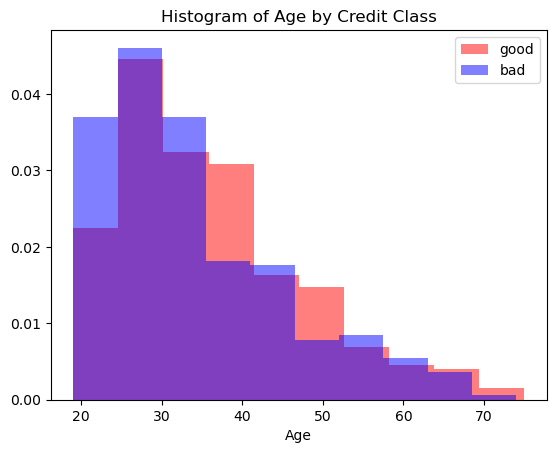

In [605]:
# plot the share of population in different classes of credit Amount

plt.hist(df[df.credit_class=='good']['age'], alpha=0.5, label='good', color='red',density=True)
plt.hist(df[df.credit_class=='bad']['age'], alpha=0.5, label='bad', color='blue',density=True)
plt.xlabel("Age")
plt.legend()
plt.title("Histogram of Age by Credit Class")

plt.show()

### duration

In [606]:
# what is the average value of duration?
calc = df["duration"].describe()
print('\nAverage Duration in months')
print(calc)


Average Duration in months
count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        72.000000
Name: duration, dtype: float64


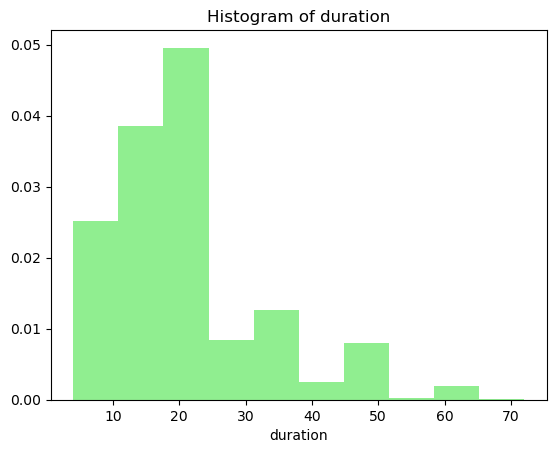

In [607]:
plt.hist(df['duration'], color='lightgreen',  density=True)
plt.xlabel("duration")
plt.title("Histogram of duration")

plt.show()

In [608]:
# what is the average value of  duration by credit class?
calc = df.groupby(['credit_class']).agg(Mean = ('duration', 'mean'),
                                        Std = ('duration', 'std')).reset_index()
print('\nAverage duration by credit class')
print(calc)


Average duration by credit class
  credit_class       Mean        Std
0          bad  24.860000  13.282639
1         good  19.207143  11.079564


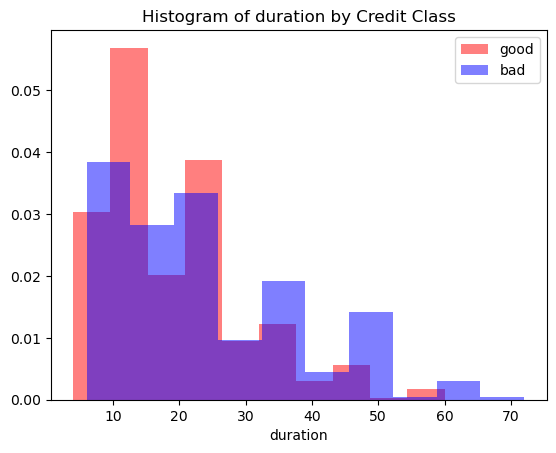

In [609]:
# plot the share of population in different classes of credit Amount

plt.hist(df[df.credit_class=='good']['duration'], alpha=0.5, label='good', color='red',density=True)
plt.hist(df[df.credit_class=='bad']['duration'], alpha=0.5, label='bad', color='blue',density=True)
plt.xlabel("duration")
plt.legend()
plt.title("Histogram of duration by Credit Class")

plt.show()

They also tend to have smaller duration of credit. The histogram of bad customers is clearly more skewed to the right that that of good customers

### Account Balance

**Levels** 

'no checking' : No Account\
'<0' : No balance or debit\
'0<=X<200' : 0 to 200DM\
'>=200' : greater than or equal to 200 DM

In [610]:
var = 'account_bal_new'
df_account_bal =  groupby_counts(df, var)
print('\nDistribution of ' + var + ':\n')
print(df_account_bal)


Distribution of account_bal_new:

  account_bal_new  Total  good  bad  DefaultRate
0               0    394   348   46     0.116751
1               1    274   139  135     0.492701
2               2    269   164  105     0.390335
3               3     63    49   14     0.222222


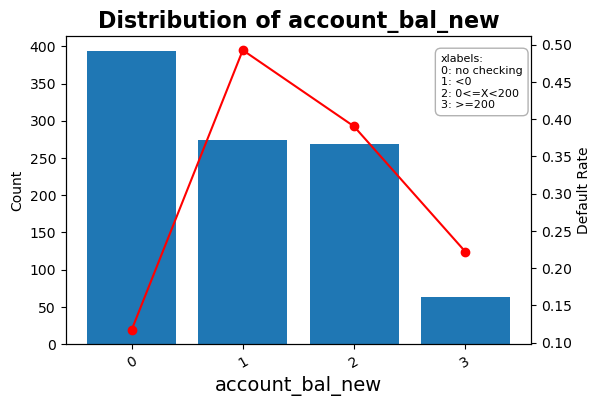

In [611]:
plot_distribution(df_account_bal, var, account_bal_map,(0.75,0.7))

### credit history

critical/other existing credit\
existing paid\
delayed previously\
no credits/all paid\
all paid


In [612]:
var = 'credit_history_new'
df_credit_history =  groupby_counts(df, var)
print('\nDistribution of credit_history:\n')
print(df_credit_history)


Distribution of credit_history:

  credit_history_new  Total  good  bad  DefaultRate
0                  0    293   243   50     0.170648
1                  1    530   361  169     0.318868
2                  2     88    60   28     0.318182
3                  3     40    15   25     0.625000
4                  4     49    21   28     0.571429


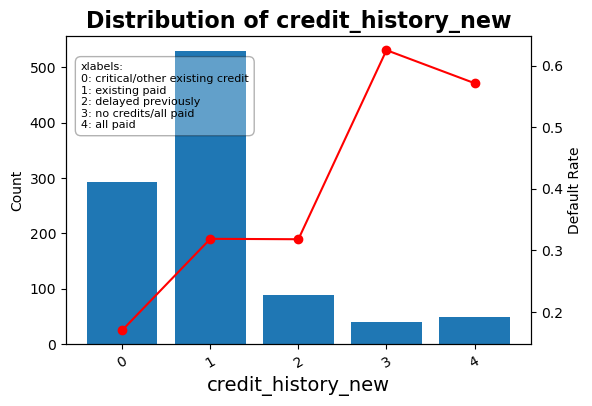

In [613]:
plot_distribution(df_credit_history, var, credit_history_map, (0.15,0.65))

### Personal status

male single: male single\
male div/sep: male divorced / living apart\
male mar/wid :male married / widowed\
female div/dep/mar: female



In [614]:
df_personal_status =  groupby_counts(df, 'personal_status')
print('\nDistribution of personal_status:\n')
print(df_personal_status)


Distribution of personal_status:

      personal_status  Total  good  bad  DefaultRate
0  female div/dep/mar    310   201  109     0.351613
1        male div/sep     50    30   20     0.400000
2        male mar/wid     92    67   25     0.271739
3         male single    548   402  146     0.266423


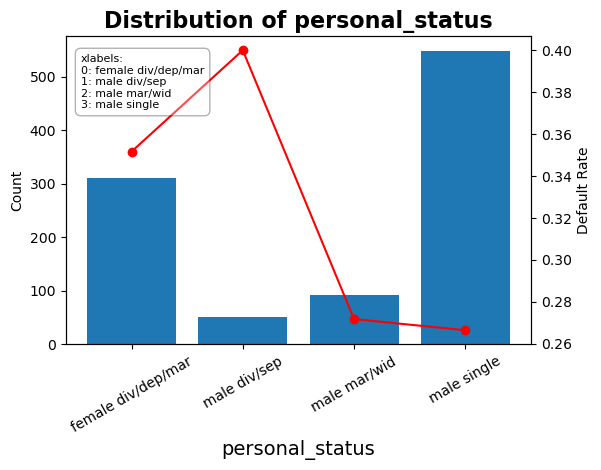

In [615]:
plot_distribution(df_personal_status, 'personal_status', personal_status_map, (0.15,0.7))

### Number of Dependents

2: 0 to 2\
1: 3 and more

In [616]:
df_num_dependents =  groupby_counts(df, 'num_dependents')
df_num_dependents['num_dependents'] = df_num_dependents['num_dependents'].astype(str)
print('\nDistribution of num_dependents:\n')
print(df_num_dependents)


Distribution of num_dependents:

  num_dependents  Total  good  bad  DefaultRate
0              1    845   591  254     0.300592
1              2    155   109   46     0.296774


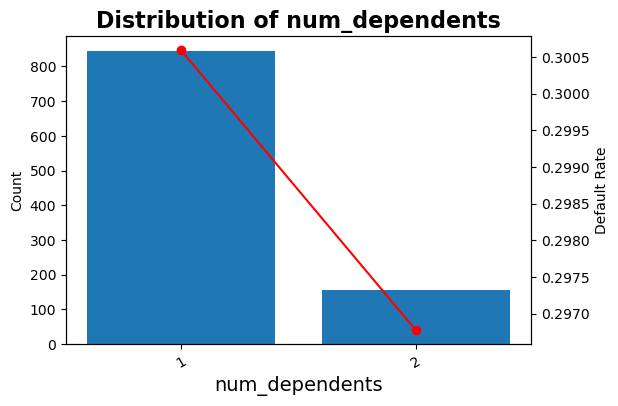

In [617]:
plot_distribution(df_num_dependents, 'num_dependents')

### Value of Savings

'no known savings'\
'<100'\
'100<=X<500'\
'500<=X<1000'\
'>=1000'

In [618]:
df_savings_value =  groupby_counts(df, 'savings_value_new')
print('\nDistribution of savings_value:\n')
print(df_savings_value)


Distribution of savings_value:

  savings_value_new  Total  good  bad  DefaultRate
0                 0    183   151   32     0.174863
1                 1    603   386  217     0.359867
2                 2    103    69   34     0.330097
3                 3     63    52   11     0.174603
4                 4     48    42    6     0.125000


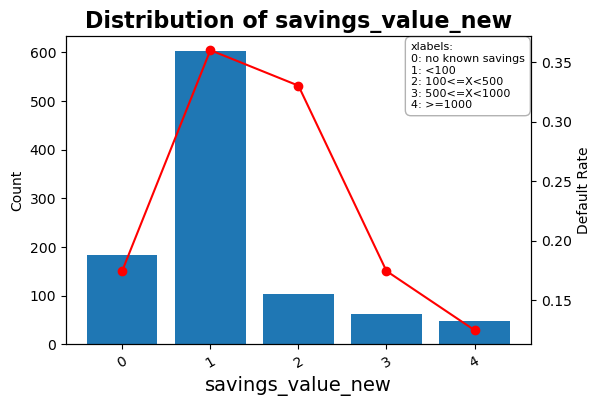

In [619]:
plot_distribution(df_savings_value, 'savings_value_new', savings_value_map, (0.7,0.7))

### Job category

'skilled'\
'unskilled resident'\
'unskilled resident'\
'unemp/unskilled non res'

In [620]:
df_job =  groupby_counts(df, 'job_new')
print('\nDistribution of job:\n')
print(df_job)


Distribution of job:

  job_new  Total  good  bad  DefaultRate
0       0    630   444  186     0.295238
1       1    200   144   56     0.280000
2       2     22    15    7     0.318182
3       4    148    97   51     0.344595


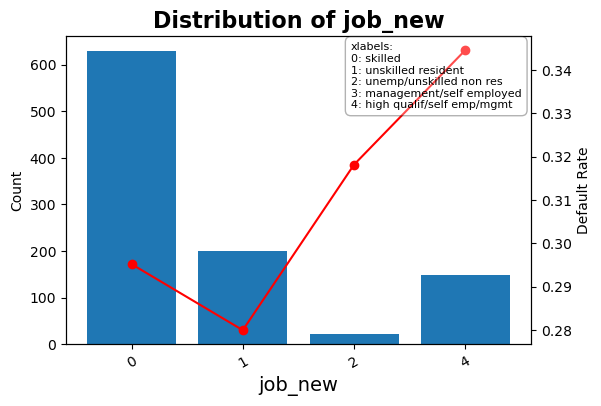

In [621]:
plot_distribution(df_job, 'job_new', job_map, (0.6,0.7))

The distribution for good and bad customers seem to be similar across various categories so job does not seem to influence creditability.

### housing

'own'\
'for free'\
'rent'

In [622]:
df_housing =  groupby_counts(df, 'housing_new')
print('\nDistribution of housing:\n')
print(df_housing)


Distribution of housing:

  housing_new  Total  good  bad  DefaultRate
0           0    713   527  186     0.260870
1           1    108    64   44     0.407407
2           2    179   109   70     0.391061


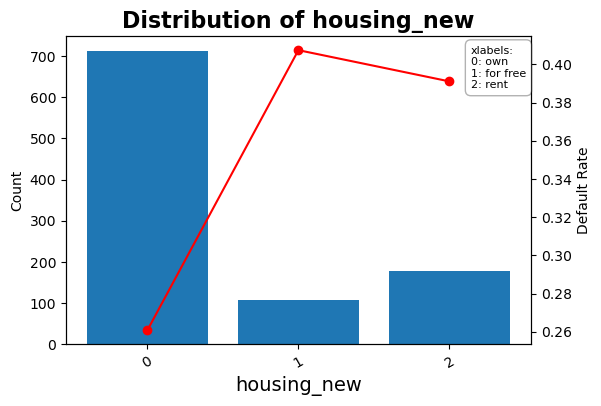

In [623]:
plot_distribution(df_housing, 'housing_new', housing_map, (0.8,0.75))

### Purpose

In [624]:
df_purpose =  groupby_counts(df, 'purpose_new')
print('\nDistribution of purpose:\n')
print(df_purpose)


Distribution of purpose:

  purpose_new  Total  good  bad  DefaultRate
0           0    280   218   62     0.221429
1           1    181   123   58     0.320442
2           2     12     8    4     0.333333
3           3     22    14    8     0.363636
4           4     50    28   22     0.440000
5           5     12     7    5     0.416667
6           6     97    63   34     0.350515
7           7    103    86   17     0.165049
8           8    234   145   89     0.380342
9           9      9     8    1     0.111111


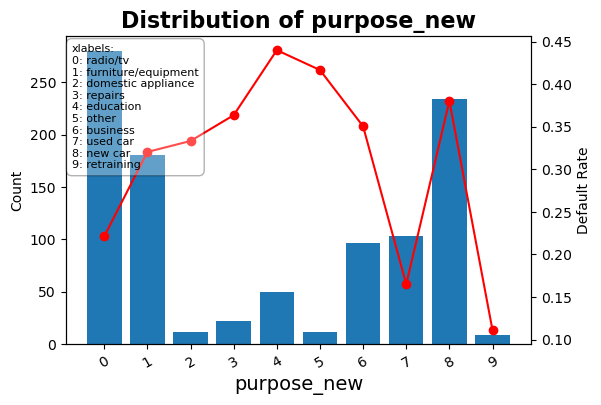

In [625]:
plot_distribution(df_purpose, 'purpose_new', purpose_map, (0.135,0.55))

### employment

In [626]:
df_employment =  groupby_counts(df, 'employment_new')
print('\nDistribution of employment:\n')
print(df_employment)


Distribution of employment:

  employment_new  Total  good  bad  DefaultRate
0              0     62    39   23     0.370968
1              1    172   102   70     0.406977
2              2    339   235  104     0.306785
3              3    174   135   39     0.224138
4              4    253   189   64     0.252964


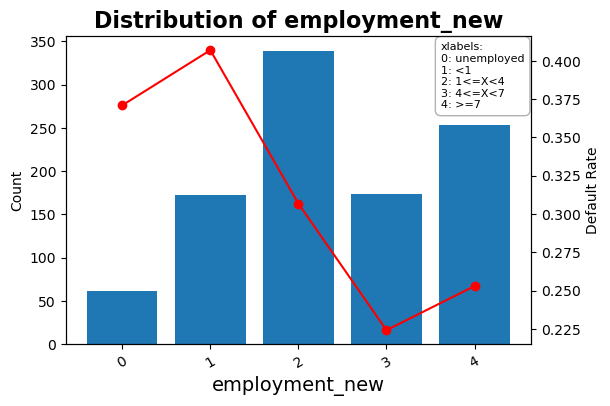

In [627]:
plot_distribution(df_employment, 'employment_new', employment_map, (0.75,0.7))

### Foreign Worker

In [628]:
df_foreign_worker =  groupby_counts(df, 'foreign_worker')
print('\nDistribution of foreign_worker:\n')
print(df_foreign_worker)


Distribution of foreign_worker:

  foreign_worker  Total  good  bad  DefaultRate
0             no     37    33    4     0.108108
1            yes    963   667  296     0.307373


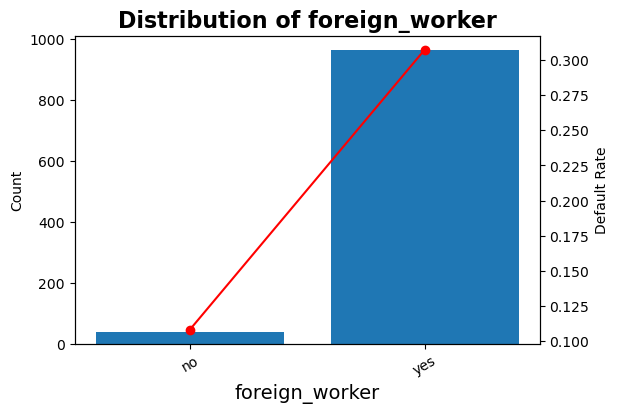

In [629]:
plot_distribution(df_foreign_worker, 'foreign_worker')

### Guarantors

In [630]:
df_guarantors =  groupby_counts(df, 'guarantors_new')
print('\nDistribution of guarantors:\n')
print(df_guarantors) 


Distribution of guarantors:

  guarantors_new  Total  good  bad  DefaultRate
0              0    907   635  272     0.299890
1              1     41    23   18     0.439024
2              2     52    42   10     0.192308


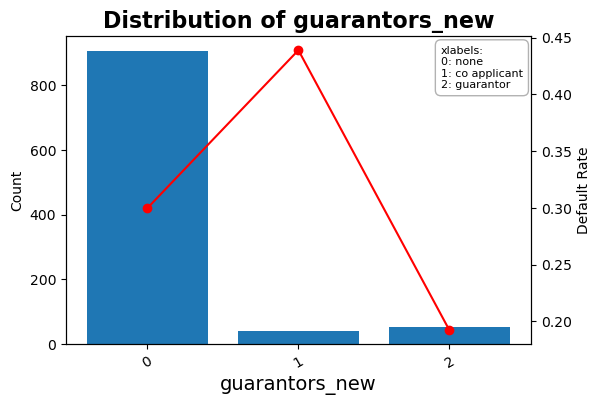

In [631]:
plot_distribution(df_guarantors, 'guarantors_new', guarantors_map, (0.75,0.75))

### Other Payment Plans

In [632]:
df_other_payment_plans =  groupby_counts(df, 'other_payment_plans_new')
print('\nDistribution of other_payment_plans:\n')
print(df_other_payment_plans) 


Distribution of other_payment_plans:

  other_payment_plans_new  Total  good  bad  DefaultRate
0                       0    139    82   57     0.410072
1                       1     47    28   19     0.404255
2                       2    814   590  224     0.275184


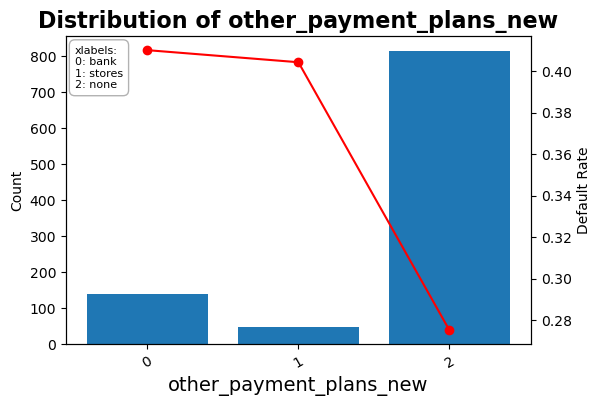

In [633]:
plot_distribution(df_other_payment_plans, 'other_payment_plans_new', other_payment_plans_map, (0.14,0.75))

### Installment rate

In [634]:
df_installment_commitment =  groupby_counts(df, 'installment_commitment')
print('\nDistribution of installment rate:\n')
print(df_installment_commitment) 


Distribution of installment rate:

   installment_commitment  Total  good  bad  DefaultRate
0                       1    136   102   34     0.250000
1                       2    231   169   62     0.268398
2                       3    157   112   45     0.286624
3                       4    476   317  159     0.334034


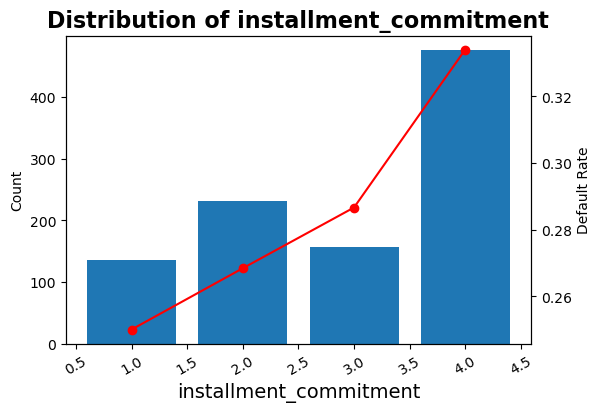

In [635]:
plot_distribution(df_installment_commitment, 'installment_commitment')

### Property Magnitude

In [636]:
df_property_magnitude =  groupby_counts(df, 'property_magnitude_new')
print('\nDistribution of Property:\n')
print(df_property_magnitude) 


Distribution of Property:

  property_magnitude_new  Total  good  bad  DefaultRate
0                      0    282   222   60     0.212766
1                      1    232   161   71     0.306034
2                      2    332   230  102     0.307229
3                      3    154    87   67     0.435065


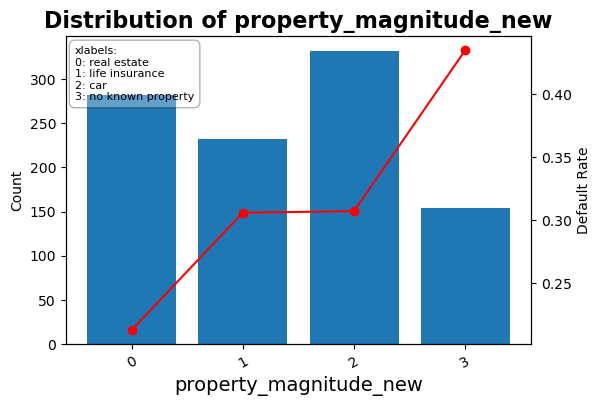

In [637]:
plot_distribution(df_property_magnitude, 'property_magnitude_new', property_magnitude_map, (0.14,0.72))

## Data Transformation

In [638]:
# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(df[numvars]))
numdata_std.columns = [i + '_std' for i in numvars]
df = pd.concat([df, numdata_std], axis=1)

## Correlation/Association Analysis

### **Numeric Columns**

In [639]:
df.columns

Index(['age', 'account_bal', 'credit_class', 'credit_amount', 'credit_history',
       'duration', 'employment', 'existing_credits', 'foreign_worker',
       'housing', 'installment_commitment', 'job', 'num_dependents',
       'guarantors', 'other_payment_plans', 'own_telephone', 'personal_status',
       'property_magnitude', 'purpose', 'residence_since', 'savings_value',
       'account_bal_new', 'credit_history_new', 'employment_new',
       'housing_new', 'job_new', 'guarantors_new', 'other_payment_plans_new',
       'personal_status_new', 'property_magnitude_new', 'purpose_new',
       'savings_value_new', 'age_std', 'credit_amount_std',
       'residence_since_std', 'installment_commitment_std', 'duration_std'],
      dtype='object')

In [640]:
numcols = ['age_std', 'credit_amount_std', 'residence_since_std', 'installment_commitment_std', 'duration_std']

In [641]:
corr_table = continuous_correlation_table(df, numcols)
corr_table.sort_values(by="pearson_rho", ascending=False)

,variable1,variable2,pearson_rho,pearson_p,spearman_rho,spearman_p
6,credit_amount_std,duration_std,0.624984,1.862851e-109,0.624709,2.469459e-109
1,age_std,residence_since_std,0.266419,1.037262e-17,0.234709,5.556995e-14
9,installment_commitment_std,duration_std,0.074749,1.807312e-02,0.118046,1.830230e-04
2,age_std,installment_commitment_std,0.058266,6.550689e-02,0.072157,2.249409e-02
7,residence_since_std,installment_commitment_std,0.049302,1.192154e-01,0.047507,1.332839e-01
8,residence_since_std,duration_std,0.034067,2.818090e-01,0.043671,1.676132e-01
0,age_std,credit_amount_std,0.032716,3.013388e-01,0.026298,4.061243e-01
4,credit_amount_std,residence_since_std,0.028926,3.608336e-01,0.023646,4.551134e-01
3,age_std,duration_std,-0.036136,2.535887e-01,-0.036316,2.512300e-01
5,credit_amount_std,installment_commitment_std,-0.271316,2.472326e-18,-0.313100,3.492654e-24


### **Categorical Columns**

In [649]:
cat_columns = [
'account_bal_new', 'credit_history_new', 'personal_status_new',
'savings_value_new', 'employment_new','housing_new', 'job_new', 'guarantors_new', 'other_payment_plans_new',
'property_magnitude_new', 'purpose_new']

In [650]:
association_table = categorical_association_table(df, cat_columns)
association_table.sort_values(by="Cramér's V", ascending=False)

,variable1,variable2,Cramér's V,Chi-Square p-value
43,housing_new,property_magnitude_new,0.553181,5.960170e-129
35,employment_new,job_new,0.311312,4.109783e-55
16,credit_history_new,other_payment_plans_new,0.215368,1.274383e-16
44,housing_new,purpose_new,0.210169,2.861352e-11
54,property_magnitude_new,purpose_new,0.205818,6.347286e-15
48,job_new,purpose_new,0.202844,2.748555e-14
21,personal_status_new,housing_new,0.202165,1.559793e-15
47,job_new,property_magnitude_new,0.193905,3.958440e-20
2,account_bal_new,savings_value_new,0.175569,1.636530e-14
34,employment_new,housing_new,0.172929,5.081439e-10


In [651]:
# Filter for practical significance
meaningful_associations = association_table[
    (association_table["Chi-Square p-value"] < 0.05) & 
    (association_table["Cramér's V"] >= 0.20)  # Moderate or stronger
].sort_values("Cramér's V", ascending=False)

meaningful_associations

,variable1,variable2,Cramér's V,Chi-Square p-value
43,housing_new,property_magnitude_new,0.553181,5.960170e-129
35,employment_new,job_new,0.311312,4.109783e-55
16,credit_history_new,other_payment_plans_new,0.215368,1.274383e-16
44,housing_new,purpose_new,0.210169,2.861352e-11
54,property_magnitude_new,purpose_new,0.205818,6.347286e-15
48,job_new,purpose_new,0.202844,2.748555e-14
21,personal_status_new,housing_new,0.202165,1.559793e-15


### Housing vs Property

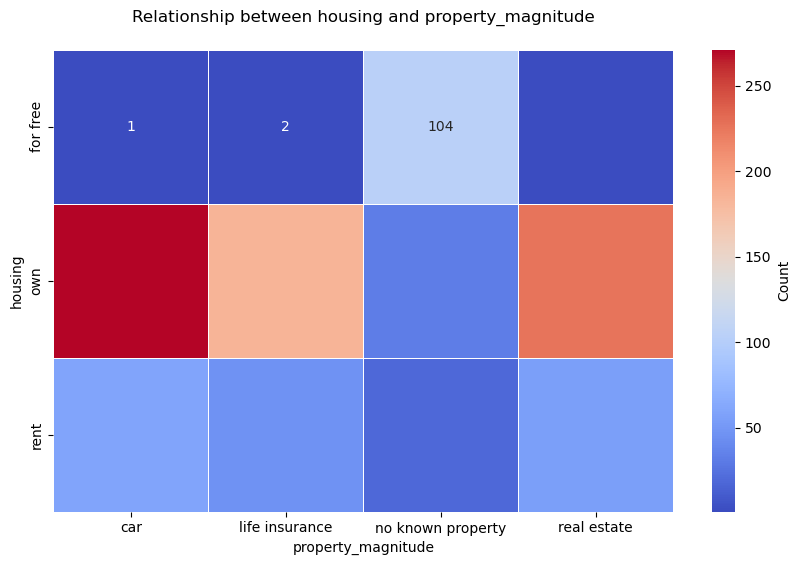

In [647]:
plot_categorical_heatmap(df, 'housing', 'property_magnitude')

### Job vs Property

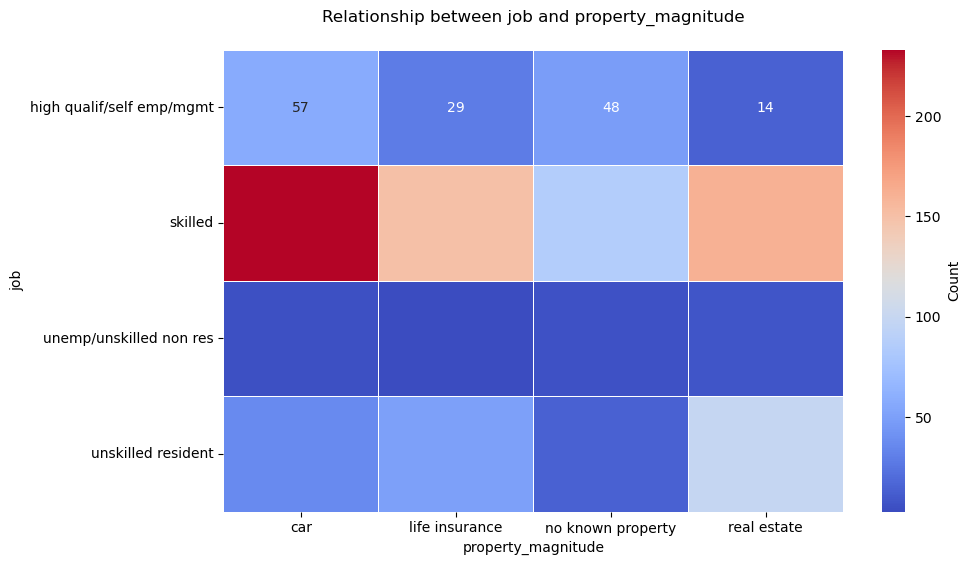

In [381]:
plot_categorical_heatmap(df, 'job', 'property_magnitude')

### Credit History vs Other Payment plans

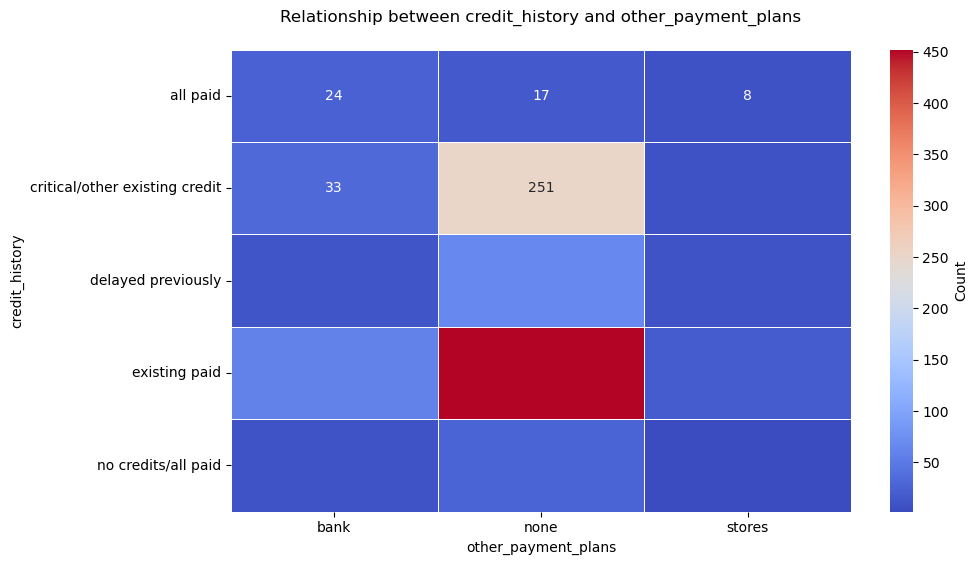

In [ ]:
plot_categorical_heatmap(df, 'credit_history', 'other_payment_plans')

### Job vs Employment

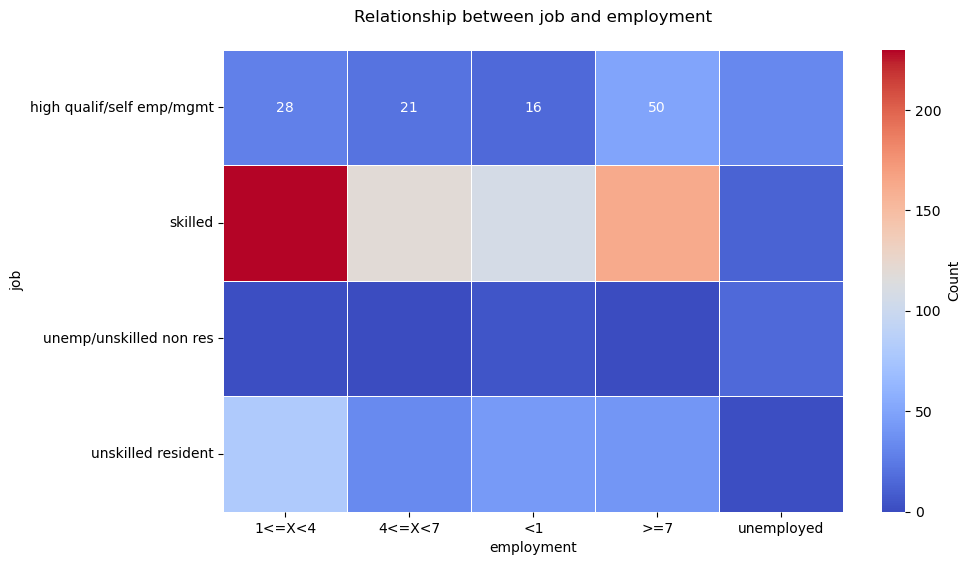

In [648]:
plot_categorical_heatmap(df, 'job', 'employment')

### Housing vs Purpose

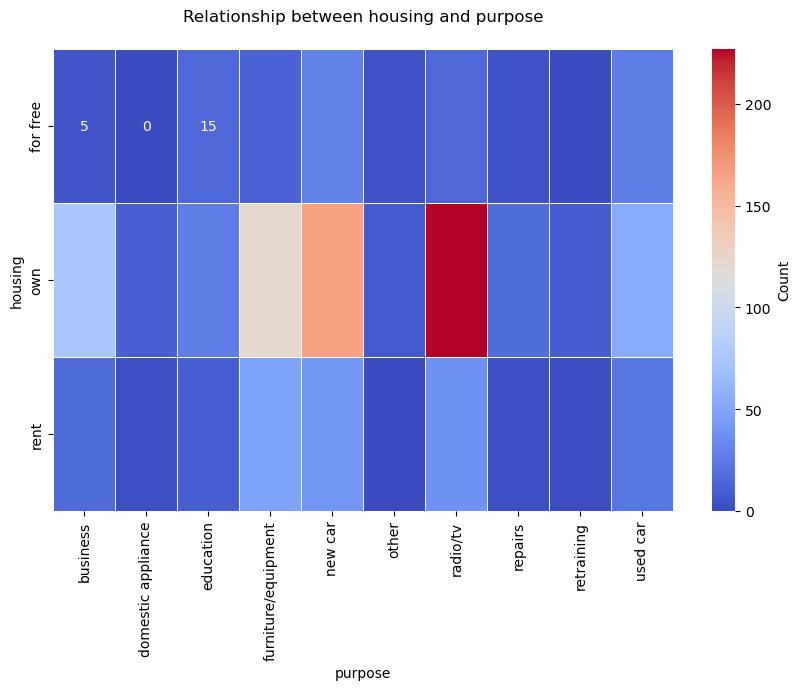

In [70]:
plot_categorical_heatmap(df, 'housing', 'purpose')

### Job vs Purpose

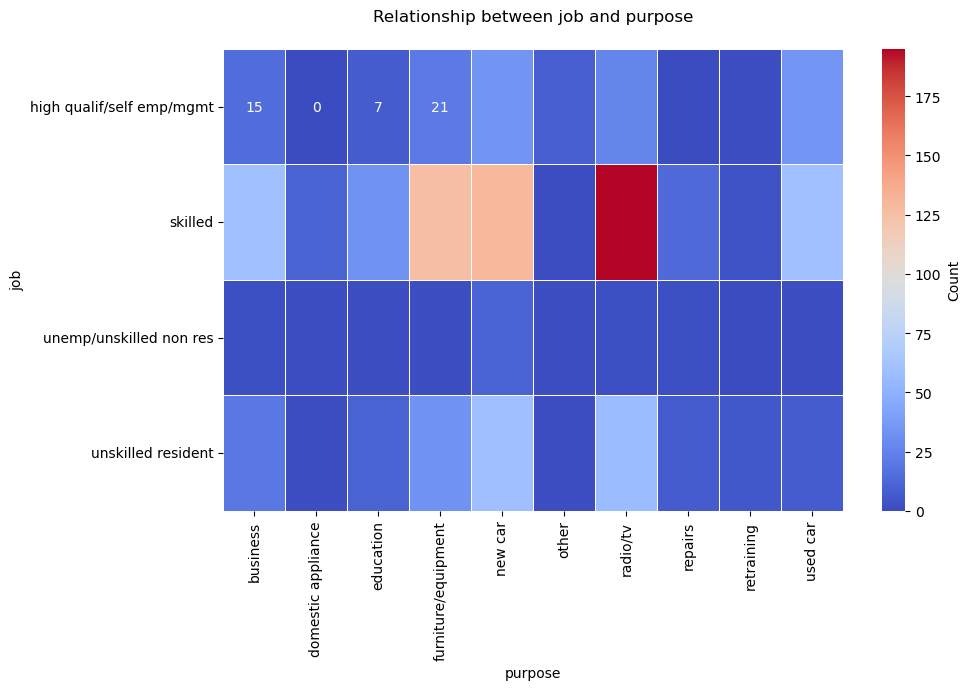

In [71]:
plot_categorical_heatmap(df, 'job', 'purpose')

## Perform Modeling Techniques

### **LogisticRegression**

In [652]:
df.columns

Index(['age', 'account_bal', 'credit_class', 'credit_amount', 'credit_history',
       'duration', 'employment', 'existing_credits', 'foreign_worker',
       'housing', 'installment_commitment', 'job', 'num_dependents',
       'guarantors', 'other_payment_plans', 'own_telephone', 'personal_status',
       'property_magnitude', 'purpose', 'residence_since', 'savings_value',
       'account_bal_new', 'credit_history_new', 'employment_new',
       'housing_new', 'job_new', 'guarantors_new', 'other_payment_plans_new',
       'personal_status_new', 'property_magnitude_new', 'purpose_new',
       'savings_value_new', 'age_std', 'credit_amount_std',
       'residence_since_std', 'installment_commitment_std', 'duration_std'],
      dtype='object')

In [143]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats

In [655]:
X = pd.get_dummies(df[['account_bal_new', 
                  'credit_history_new', 
                  'employment_new',
                  'existing_credits',
                  'foreign_worker',
                  'housing_new', 
                  'job_new', 
                  'guarantors_new', 
                  'other_payment_plans_new',       
                  'personal_status_new', 
                  'property_magnitude_new', 
                #  'purpose_new',       
                  'savings_value_new', 
                  'age_std', 
                  'credit_amount_std',       
                  'residence_since_std', 
                  'installment_commitment_std', 
                  'duration_std'
    ]],drop_first=True)

y = df['credit_class'].map({'good':0, 'bad':1})

In [656]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12,stratify=df['credit_class'] )

In [657]:
X_train.shape

(750, 37)

In [672]:
LogisticModel = LogisticRegression(max_iter=10000, random_state=12)
LogisticModel.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=12)

In [673]:
y_prob = LogisticModel.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

In [674]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': LogisticModel.coef_[0]
}).sort_values('Feature', ascending=False)

coef_df

,Feature,Coefficient
36,savings_value_new_4,-0.087405
35,savings_value_new_3,0.513741
34,savings_value_new_2,0.747476
33,savings_value_new_1,1.096190
3,residence_since_std,-0.007308
32,property_magnitude_new_3,0.810640
31,property_magnitude_new_2,0.318995
30,property_magnitude_new_1,0.130773
29,personal_status_new_3,-0.209287
28,personal_status_new_2,-0.655144


In [675]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[155  20]
 [ 47  28]]
              precision    recall  f1-score   support

           0       0.77      0.89      0.82       175
           1       0.58      0.37      0.46        75

    accuracy                           0.73       250
   macro avg       0.68      0.63      0.64       250
weighted avg       0.71      0.73      0.71       250



**Logistic Regression with resampling**

In [676]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE
sm = SMOTE(sampling_strategy='auto')

X_train_re, y_train_re = sm.fit_resample(X_train, y_train)

In [677]:
LogisticModel = LogisticRegression(max_iter=10000, random_state=12)
LogisticModel.fit(X_train_re, y_train_re)

LogisticRegression(max_iter=10000, random_state=12)

In [716]:
y_prob = LogisticModel.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

In [717]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79       175
           1       0.51      0.45      0.48        75

    accuracy                           0.70       250
   macro avg       0.64      0.63      0.64       250
weighted avg       0.70      0.70      0.70       250

[[142  33]
 [ 41  34]]


In [718]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

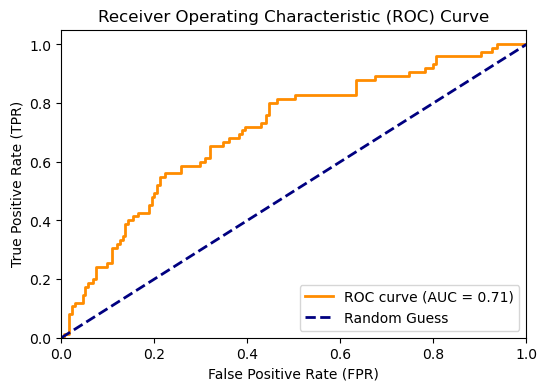

In [719]:
plot_roc_curve(fpr, tpr, roc_auc)

### **RandomForest**

In [697]:
# Initialize the model with class weighting to handle imbalance
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=13,
    class_weight='balanced'  # Adjusts for class imbalance
)
#rf.fit(X_train, y_train)
rf.fit(X_train_re, y_train_re)

RandomForestClassifier(class_weight='balanced', random_state=13)

In [698]:
# Predict on the test set
y_pred = rf.predict(X_test)

In [699]:
# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.81       175
           1       0.53      0.39      0.45        75

    accuracy                           0.71       250
   macro avg       0.65      0.62      0.63       250
weighted avg       0.69      0.71      0.70       250


Confusion Matrix:
[[149  26]
 [ 46  29]]


**RandomForest with Gridsearch (optimal parameters)**

In [700]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=5,
    scoring='f1_macro'  # Focus on F1-score for both classes
)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

In [694]:
best_rf.fit(X_train_re, y_train_re)
y_pred = best_rf.predict(X_test)

In [695]:
# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       175
           1       0.56      0.47      0.51        75

    accuracy                           0.73       250
   macro avg       0.68      0.66      0.66       250
weighted avg       0.72      0.73      0.72       250


Confusion Matrix:
[[148  27]
 [ 40  35]]


In [ ]:
# Get predicted probabilities for class 1 (bad credit)
y_probs = best_rf.predict_proba(X_test)[:, 1]  # For Random Forest

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

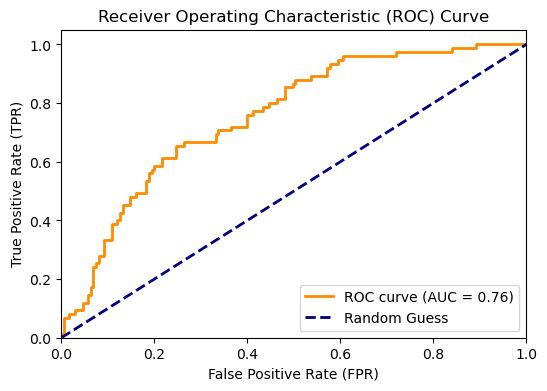

In [706]:
plot_roc_curve(fpr, tpr, roc_auc)

### **Support Vector Classifier**

In [710]:
svc = svm.SVC(kernel='poly',degree=1,probability=True,C=2,class_weight="balanced")
svc.fit(X_train_re, y_train_re)
# Predict target variables y for test data
y_pred = svc.predict(X_test)

In [711]:
# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       175
           1       0.50      0.47      0.48        75

    accuracy                           0.70       250
   macro avg       0.64      0.63      0.64       250
weighted avg       0.69      0.70      0.70       250


Confusion Matrix:
[[140  35]
 [ 40  35]]


In [712]:
# Get predicted probabilities for class 1 (bad credit)
y_probs = svc.predict_proba(X_test)[:, 1]  # For Random Forest

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

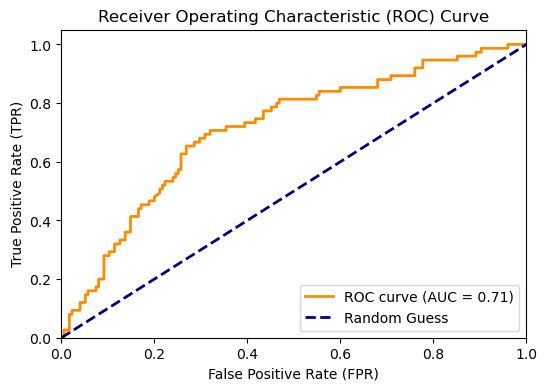

In [713]:
plot_roc_curve(fpr, tpr, roc_auc)